In [1]:
import osmnx as ox
ox.config(use_cache=True, log_console=True)

In [2]:
import matplotlib as plt

In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import networkx as nx


In [5]:
## Function to get any city within OSMNX; DIST seems to be the zoom on the street network
def create_graph(loc, dist, transport_mode, loc_type="address"):
    """Transport mode = ‘walk’, ‘bike’, ‘drive’, ‘drive_service’, ‘all’, ‘all_private’, ‘none’"""
    if loc_type == "address":
        G = ox.graph_from_address(loc, dist=dist, network_type=transport_mode)
    elif loc_type == "points":
        G = ox.graph_from_point(loc, dist=dist, network_type=transport_mode )
    return G

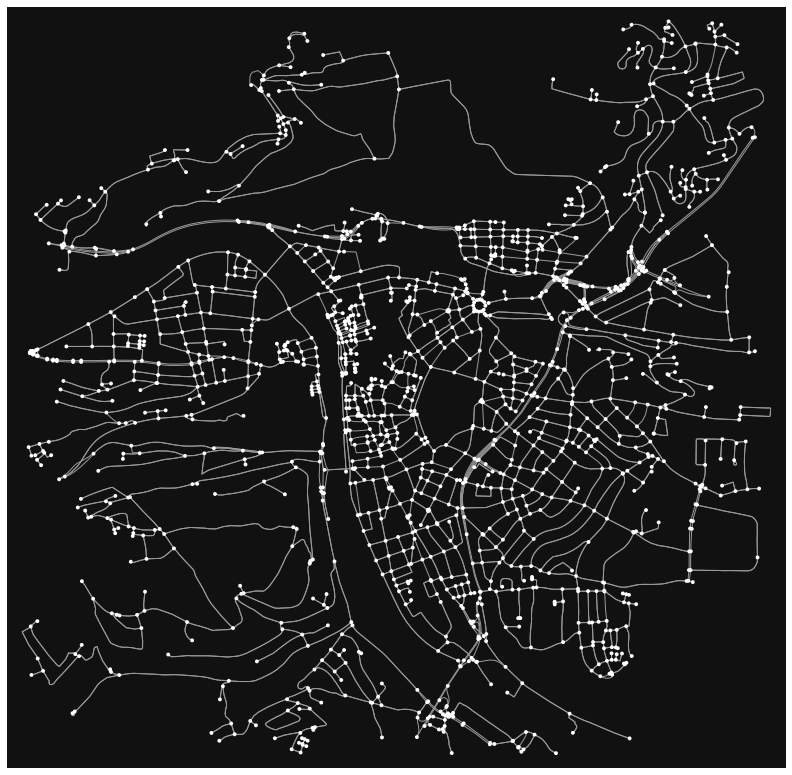

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

In [6]:
## Plot Würzburg
G = create_graph("Wuerzburg", 3000, "drive")
ox.plot_graph(G, figsize=(14, 14))

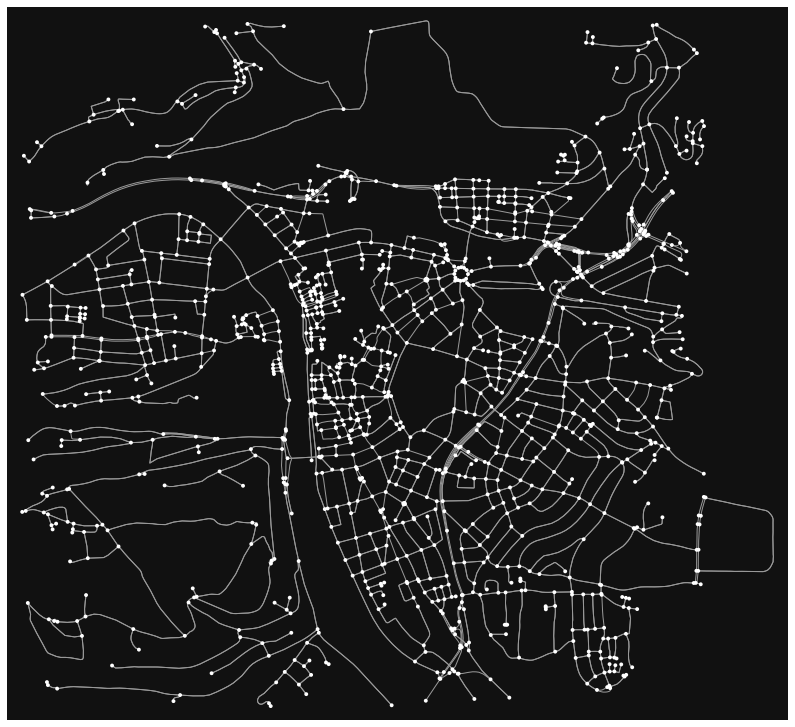

(<Figure size 1008x1008 with 1 Axes>, <AxesSubplot:>)

In [30]:
G = create_graph("Wuerzburg", 2500, "drive")
ox.plot_graph(G, figsize = (14,14))

In [7]:
## First test route
start = (49.794783, 9.906499)
end = (49.771253, 9.896912)
start_node = ox.get_nearest_node(G, start) 
end_node = ox.get_nearest_node(G, end)
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')

C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


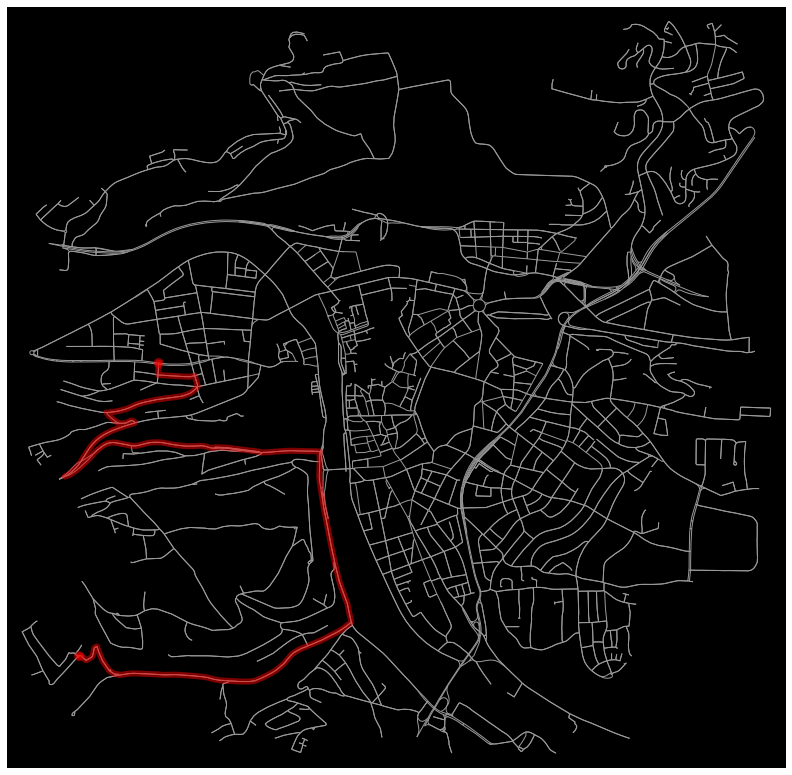

In [8]:
## Plot the route
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k',figsize= (14,14));

In [9]:
## See which streets are most central
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

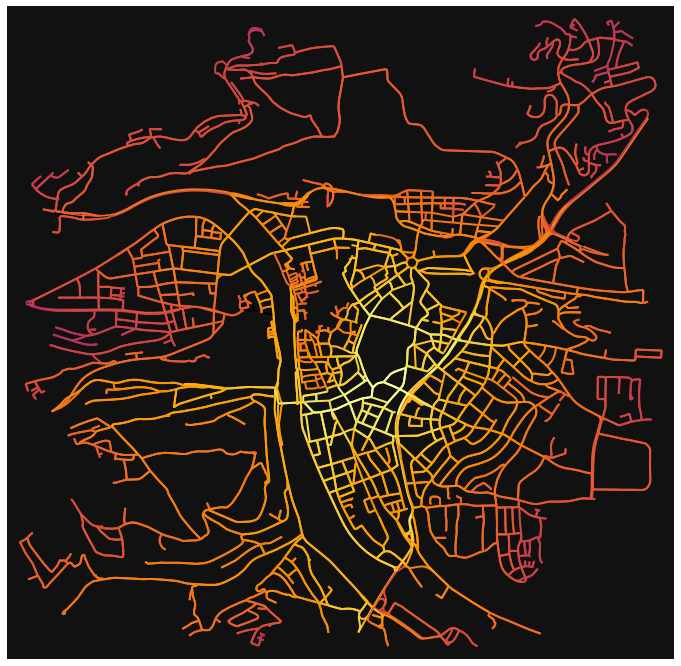

In [10]:
# Plot closeness centrality with colors
ec = ox.plot.get_edge_colors_by_attr(G, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(G, edge_color = ec, edge_linewidth=2, node_size= 0, figsize = (12,12))

In [11]:
##imputing speeds and travel times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [12]:
## Look at travel times and average speeds set for the different roads
edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph","travel_time"]].mean().round(1)

length  speed_kph  travel_time
highway                                                                 
['residential', 'living_street']           162.1       32.6         17.3
['residential', 'primary_link']            303.1       50.0         21.8
['residential', 'unclassified']            369.9       34.1         42.7
['road', 'residential', 'living_street']   338.5       15.0         81.2
['tertiary', 'primary_link']               270.5       50.0         19.5
['tertiary', 'residential']                 81.6       30.0          9.8
['trunk', 'primary']                       396.4       50.0         28.5
['trunk', 'trunk_link']                    952.6       90.0         38.1
['unclassified', 'residential']            369.9       34.4         42.5
living_street                               65.1       27.4          8.7
primary                                    157.6       49.5         11.5
primary_link                                90.8       49.6          6.7
residential                                129.1       30.6         15.3
secondary                                  141.3       49.7         10.1
secondary_link                              71.4       48.0          5.6
tertiary                                   119.9       44.9          9.9
tertiary_link                               82.1       50.0          5.9
trunk                                      263.5       57.4         14.9
trunk_link                                 111.3       50.8          7.8
unclassified                               162.1       33.6         17.4

In [13]:
## See difference in routing between dependt variable length and travel_time
start = (49.794783, 9.906499)
end = (49.771253, 9.896912)
orig = ox.get_nearest_node(G, start) 
dest = ox.get_nearest_node(G, end)
route1 = ox.shortest_path(G, orig, dest, weight= "length")
route2 = ox.shortest_path(G, orig, dest, weight= "travel_time")

C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


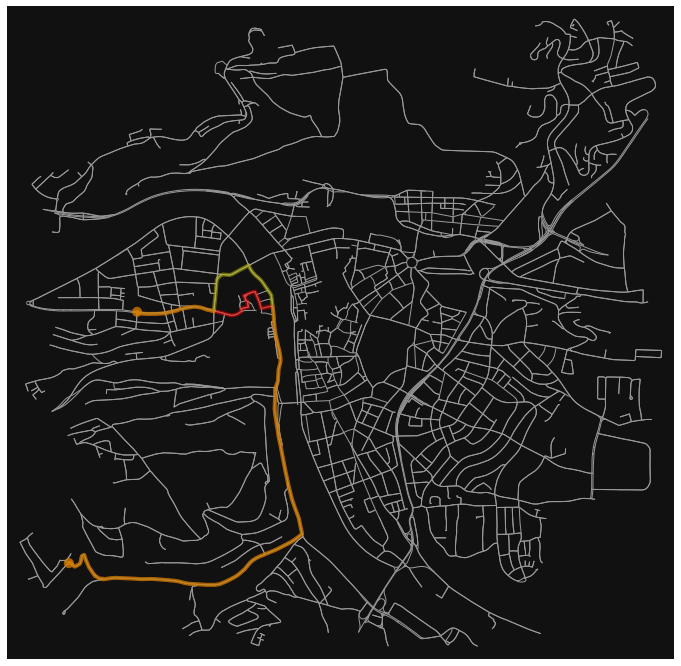

In [14]:
# plot the two routes with different colors
fig, ax = ox.plot_graph_routes(
    G, routes =[route1, route2], route_colors =["r", "y"], route_linewidth= 5, node_size = 0, figsize=(12,12)
)

In [21]:
# compare the two routes in length and travel time
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")

Route 1 is 6465 meters and takes 589 seconds.
Route 2 is 6684 meters and takes 561 seconds.


In [22]:
## Compare with crow flight distance
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
#round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))
print("Crow Flight distance between the two nodes is", round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x)), "meters")

Crow Flight distance between the two nodes is 2484 meters


In [ ]:
## Manual plotting of the route that OR-Tools suggested for our delivery 0-5-2-1-3-4-0

## Define the Points, inlcuding depot twice
start = (49.794783, 9.906499)
dest1 = (49.771253, 9.896912)
dest2 = (49.763673, 9.891435)
dest3 = (49.725430, 9.913011)
dest4 = (49.741401, 9.866122)
dest5 = (49.790065, 9.868400)
dest6 = (49.794783, 9.906499)
## Get the nearest nodes for routing
depot_node = ox.get_nearest_node(G, start) 
drop1 = ox.get_nearest_node(G, dest1)
drop2 = ox.get_nearest_node(G, dest2)
drop3 = ox.get_nearest_node(G, dest3)
drop4 = ox.get_nearest_node(G, dest4)
drop5 = ox.get_nearest_node(G, dest5)
depot_node2 = ox.get_nearest_node(G, dest6)
## Define the routes 0-5-2-1-3-4-0
route1 = ox.shortest_path(G, depot_node, drop1, weight = "length")
route2 = ox.shortest_path(G, drop1, drop2, weight = "length")
route3 = ox.shortest_path(G, drop2, drop3, weight = "length")
route4 = ox.shortest_path(G, drop3, drop4, weight = "length")
route5 = ox.shortest_path(G, drop4, drop5, weight = "length")
route6 = ox.shortest_path(G, drop5, depot_node2, weight = "length")

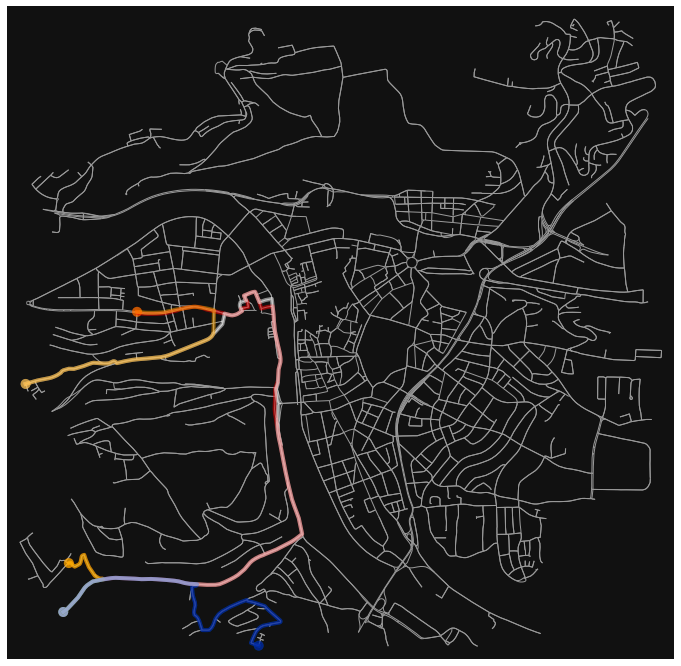

In [30]:
## PLot the routes
fig, ax = ox.plot_graph_routes(
    G, routes =[route1, route2, route3, route4, route5, route6], route_colors =["red", "yellow", "green", "blue", "white", "orange"], route_linewidth= 4, node_size = 0, figsize=(12,12)
)

In [ ]:
ox.plot.plot_graph(G, node_size =8, figsize= (12,12), edge_color="blue", edge_linewidth=2, node_color = "yellow") 

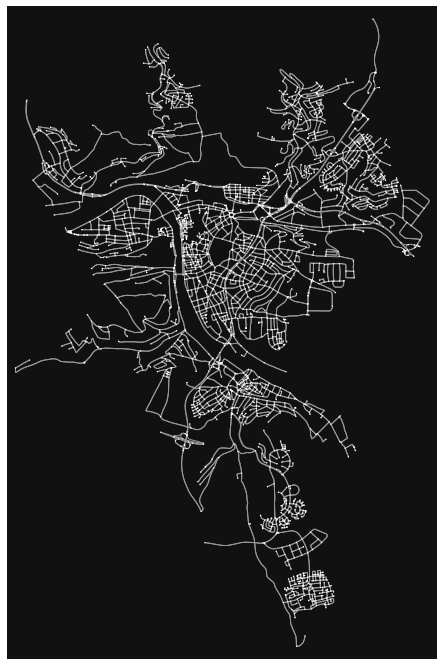

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [4]:
place = {"city": "Wuerzburg", "country": "Germany"}
F = ox.graph_from_place(place, network_type="drive")
ox.plot.plot_graph(F, figsize=(12,12), node_size = 2)

In [ ]:
start = (49.794783, 9.906499)
end = (49.771253, 9.896912)
orig = ox.get_nearest_node(F, start) 
dest = ox.get_nearest_node(F, end)
route1 = ox.shortest_path(F, orig, dest, weight= "length")
route2 = ox.shortest_path(F, orig, dest, weight= "travel_time")

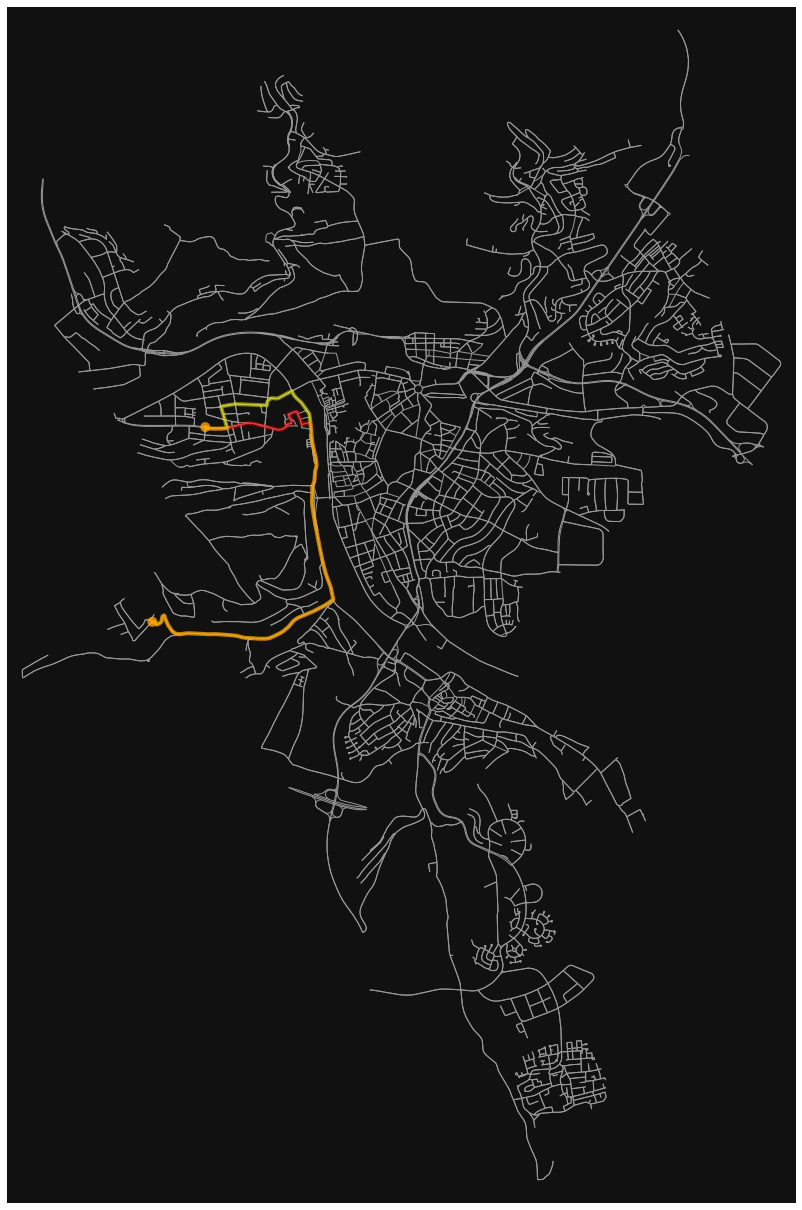

In [63]:
fig, ax = ox.plot_graph_routes(
    F, routes =[route1, route2], route_colors =["red", "yellow"], route_linewidth= 4, node_size = 0, figsize=(22,22)
)

In [90]:
depot = ox.distance.nearest_nodes(F, X= 9.906499, Y=49.794783)
drop1 = ox.distance.nearest_nodes(F, X= 9.944894 , Y=49.794177)
drop2 = ox.distance.nearest_nodes(F, X= 9.967612, Y= 49.783901)
drop3 = ox.distance.nearest_nodes(F, X= 9.937297, Y= 49.773596)
depot2 = ox.distance.nearest_nodes(F, X= 9.906499, Y=49.794783 )
route1 = ox.shortest_path(F, depot, drop1, weight= "travel_time")
route2 = ox.shortest_path(F, drop1, drop2, weight= "travel_time")
route3 = ox.shortest_path(F, drop2, drop3, weight= "travel_time")
route4= ox.shortest_path(F, drop3, depot2, weight= "travel_time")

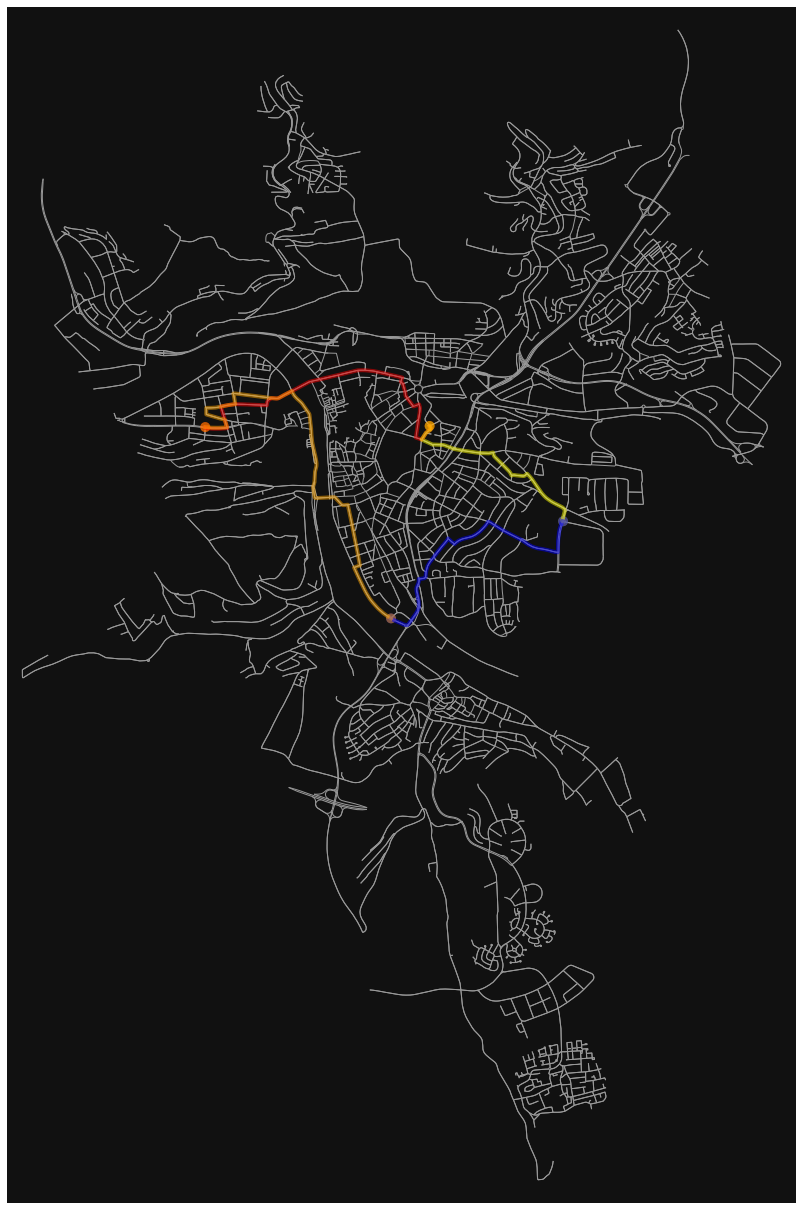

In [93]:
fig, ax = ox.plot_graph_routes(
    F, routes =[route1, route2, route3, route4], route_colors =["red", "yellow", "blue", "orange"], route_linewidth= 4, node_size = 0, figsize=(22,22)
)

In [7]:
##imputing speeds and travel times
F = ox.add_edge_speeds(F)
F = ox.add_edge_travel_times(F)

In [116]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(F, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(F, route2, "length")))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(F, route3, "length")))
route4_length = int(sum(ox.utils_graph.get_route_edge_attributes(F, route4, "length")))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route1, "travel_time")))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route2, "travel_time")))
route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route3, "travel_time")))
route4_time = int(sum(ox.utils_graph.get_route_edge_attributes(F, route4, "travel_time")))
print("Route 1 is", route1_length, "meters and takes", route1_time, "seconds.")
print("Route 2 is", route2_length, "meters and takes", route2_time, "seconds.")
print("Route 3 is", route3_length, "meters and takes", route3_time, "seconds.")
print("Route 4 is", route4_length, "meters and takes", route4_time, "seconds.")
print("Whole Trip is \033[1m", route1_length+route2_length+route3_length+route4_length, "meters \033[0m long and takes \033[1m", route1_time+route2_time+route3_time+route4_time, "seconds\033[0m")

Route 1 is 4104 meters and takes 374 seconds.
Route 2 is 2496 meters and takes 216 seconds.
Route 3 is 3460 meters and takes 335 seconds.
Route 4 is 5394 meters and takes 501 seconds.
Whole Trip is  15454 meters  long and takes  1426 seconds


In [106]:
## See which streets are most central
edge_centrality = nx.closeness_centrality(nx.line_graph(F))
nx.set_edge_attributes(F, edge_centrality, "edge_centrality")

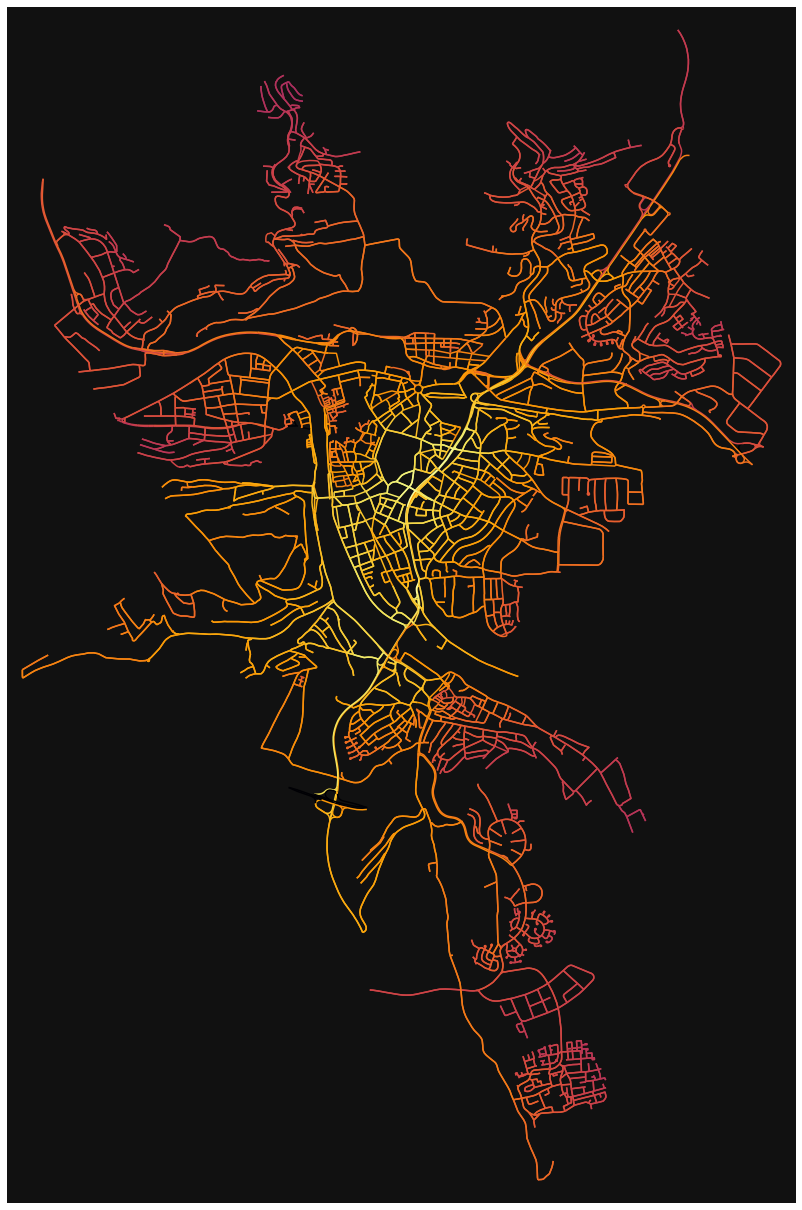

In [109]:
# Plot closeness centrality with colors
ec = ox.plot.get_edge_colors_by_attr(F, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(F, edge_color = ec, edge_linewidth=1.5, node_size= 0, figsize = (22,22))

C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


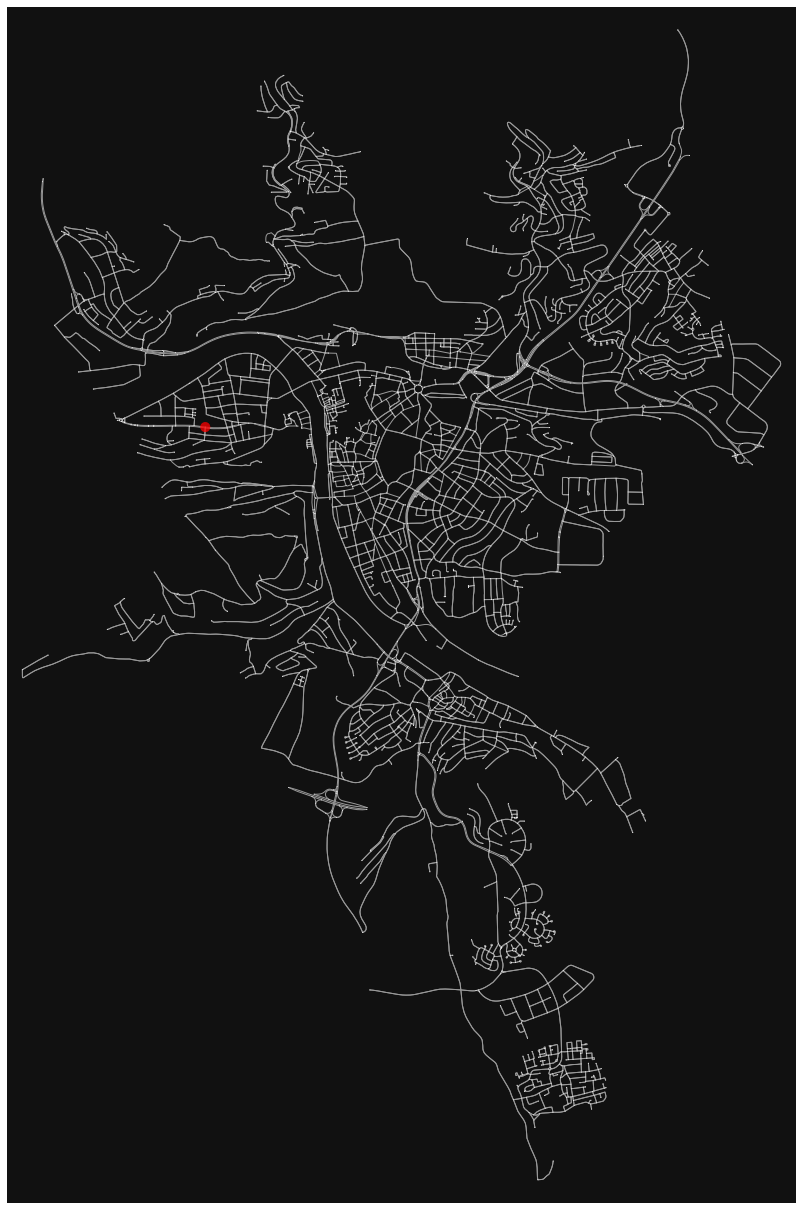

(<Figure size 1584x1584 with 1 Axes>, <AxesSubplot:>)

In [6]:
## Plotting a single node
ox.plot_graph_route(F, [ox.get_nearest_node(F, (49.794783, 9.906499))], figsize = (22,22), node_size = 1)

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
from shapely.wkt import loads as load_wkt
import numpy as np
import matplotlib.cm as cm

C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\michi\AppData\Local\Temp/ipykernel_17996/2085883122.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes['shortest_route_length_to_target'][node] = route_length
C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\matplotlib\cbook\__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


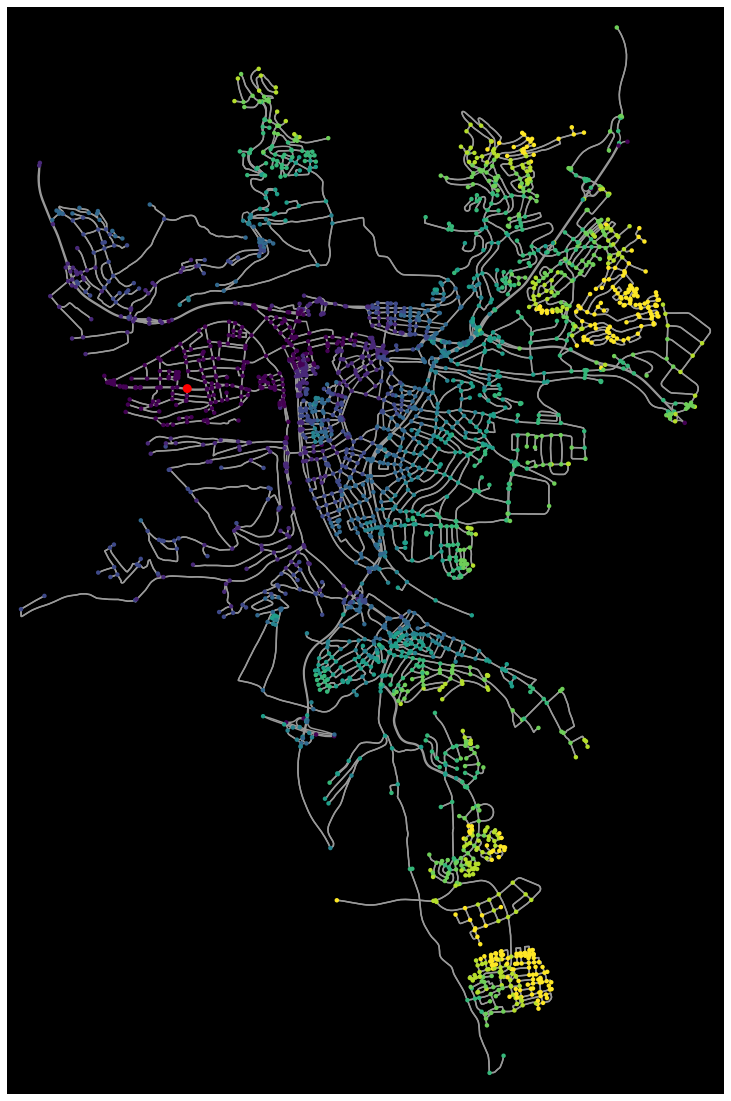

In [27]:
## Adapt the code of "Debjit" for Würzburg. This cmap shows different route lengths from the depot based on the number of edges have to be traversed to reach the node 
## (basically how many edges have to be passed, to reach the destination node)
## Edges = Street Segments, Nodes = Intersections

place = {'city': 'Wuerzburg', 'country': 'Germany'}
G = ox.graph_from_place(place, network_type='drive')


depot = (49.794783, 9.906499)
target_1 = ox.get_nearest_node(G, depot)

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

nodes['shortest_route_length_to_target'] = 0
routes = []
route_lengths = []
i = 0
for node in G.nodes:
    try:
        route = nx.shortest_path(G, node, target_1)
        route_length = nx.shortest_path_length(G, node, target_1)
        routes.append(route)
        route_lengths.append(route_length)
        nodes['shortest_route_length_to_target'][node] = route_length
    except nx.exception.NetworkXNoPath:
        continue

def get_colors(n, cmap='viridis', start=0., stop=1., alpha=1.,):

    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors


def get_node_colors_by_attr(G, attr, num_bins=None, cmap='viridis', start=0, stop=1, na_color='none'):

    if num_bins is None:
        num_bins=len(G.nodes())
    bin_labels = range(num_bins)
    attr_values = pd.Series(nodes[attr].values)
    cats = pd.qcut(x=attr_values, q=num_bins, labels=bin_labels)
    colors = get_colors(num_bins, cmap, start, stop)
    node_colors = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]
    return node_colors

nc = get_node_colors_by_attr(G, attr = 'shortest_route_length_to_target', num_bins=10,)
ns = [80 if node == target_1 else 20 for node in G.nodes()]
k = 0

for node in G.nodes():

    if node == target_1:

        nc[k] = str('red')
        k += 1
    else:g
        k += 1
        

fig, ax = ox.plot_graph(G, node_color = nc, node_size=ns, edge_linewidth = 1.5, bgcolor = "black", figsize= (20,20),)

C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\michi\AppData\Local\Temp/ipykernel_15812/3801751023.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes['shortest_route_length_to_target'][node] = route_length
C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\matplotlib\cbook\__init__.py:1061: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


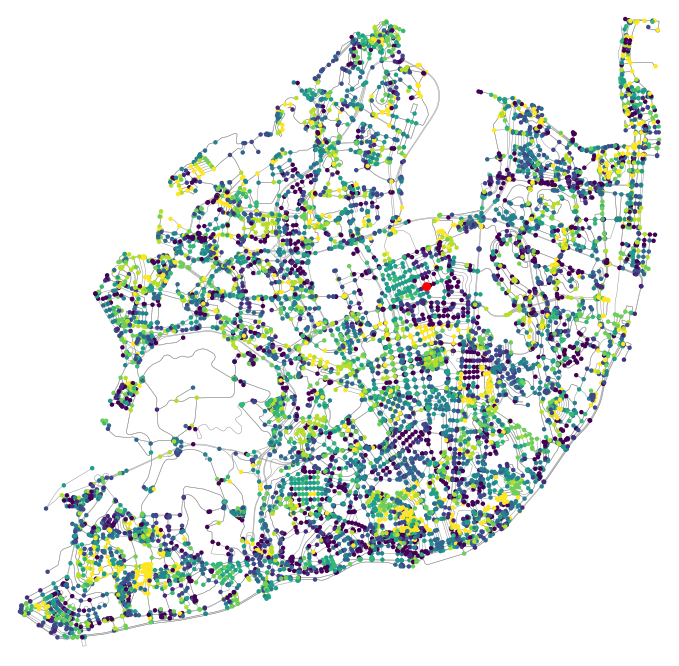

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd
from shapely.wkt import loads as load_wkt
import numpy as np
import matplotlib.cm as cm
ox.config(log_console=True, use_cache=True)

place = {'city': 'Lisbon', 'country': 'Portugal'}
G = ox.graph_from_place(place, network_type='drive')
coord_1 = (38.74817825481225, -9.160815118526642)  # Coordinate Hospital Santa Maria
target_1 = ox.get_nearest_node(G, coord_1)

#G = ox.add_edge_speeds(G)
#G = ox.add_edge_travel_times(G)

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

travel_speed = 20    # km/h
meters_per_minute = travel_speed * 1000 / 60

nodes['shortest_route_length_to_target'] = 0
route_lengths = []
i = 0
# print(G.edges(data=True))
for u, v, k, data in G.edges(data=True, keys=True):

    data['time'] = data['length'] / meters_per_minute


for node in G.nodes:
    try:
        route_length = nx.shortest_path_length(G, node, target_1, weight='time')
        route_lengths.append(route_length)
        nodes['shortest_route_length_to_target'][node] = route_length

    except nx.exception.NetworkXNoPath:
        continue


def get_colors(n, cmap='viridis', start=0., stop=1., alpha=1.):

    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors


def get_node_colors_by_attr(G, attr, num_bins=None, cmap='viridis', start=0, stop=1, na_color='none'):

    if num_bins is None:
        num_bins = len(G.nodes())
    bin_labels = range(num_bins)
    # attr_values = pd.Series([data[attr] for node, data in G.nodes(data=True)])
    attr_values = pd.Series(nodes[attr].values)  # Cretaes a dataframe ith the attribute of each node
    # print(attr_values)
    cats = pd.qcut(x=attr_values, q=num_bins, labels=bin_labels)  # Puts the values in bins
    # print(cats)
    colors = get_colors(num_bins, cmap, start, stop)  #List of colors of each bin
    node_colors = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]

    return node_colors


nc = get_node_colors_by_attr(G, attr='shortest_route_length_to_target', num_bins=10)
ns = [80 if node == target_1 else 20 for node in G.nodes()]
k = 0

for node in G.nodes():

    if node == target_1:

        nc[k] = str('red')
        k += 1
    else:
        k += 1


G = ox.project_graph(G)
cmap = plt.cm.get_cmap('viridis')
norm=plt.Normalize(vmin=nodes['shortest_route_length_to_target'].min(), vmax=nodes['shortest_route_length_to_target'].max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.5, figsize =(12,12), bgcolor = 'white', show=False)
#cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal')
#cb.set_label('shortest_route_length_to_target', fontsize = 20)
#fig.savefig('demo.png')

In [6]:
ox.basic_stats(F)

{'n': 2772,
 'm': 6657,
 'k_avg': 4.803030303030303,
 'edge_length_total': 889121.3289999984,
 'edge_length_avg': 133.56186405287644,
 'streets_per_node_avg': 2.718975468975469,
 'streets_per_node_counts': {0: 0, 1: 517, 2: 47, 3: 1913, 4: 288, 5: 7},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1865079365079365,
  2: 0.016955266955266956,
  3: 0.6901154401154401,
  4: 0.1038961038961039,
  5: 0.0025252525252525255},
 'intersection_count': 2255,
 'street_length_total': 493405.4770000007,
 'street_segment_count': 3746,
 'street_length_avg': 131.71529017618812,
 'circuity_avg': 1.0693172320973858,
 'self_loop_proportion': 0.009343299519487454}

In [6]:
#Trying to build a distance matrix, distance between each node in the network 
# Many missing values :(
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
mat_generator = nx.all_pairs_dijkstra_path_length(G, weight = "length")
mat_dict = dict(mat_generator)
mat = pd.DataFrame(mat_dict).fillna("").round(1)#.T.astype(int) #.fillna(dist_treshold).T
mat
#mat.isnull().sum().sum()

580993     10799058   10799066   10799083   10799085   10799087    \
580993            0.0    661.307   5186.516    684.132     594.85    980.947   
10799058                     0.0   4595.481     93.097    650.258    389.912   
2286505705                106.81   4632.019    129.635     40.353     426.45   
29670702                 114.915   4640.124     137.74     48.458    434.555   
10799085                 147.163   4591.666     89.282        0.0    386.097   
...               ...        ...        ...        ...        ...        ...   
27411526                                                                       
1086564265                                                                     
5369836711                                                                     
2286505721                                                                     
3733283082                                                                     

           10799089   10799100   10799937   10799942    ... 8684424129  \
580993                             3448.608   3917.497  ...   6399.148   
10799058                           2857.573   3326.462  ...   5808.113   
2286505705                         2894.111     3363.0  ...   5844.651   
29670702                           2902.216   3371.105  ...   5852.756   
10799085                           2853.758   3322.647  ...   5804.298   
...               ...        ...        ...        ...  ...        ...   
27411526                                                ...              
1086564265                                              ...              
5369836711                                              ...              
2286505721                                              ...              
3733283082                                              ...              

           8917651907 8917667635 8917667643 8917704467 8917704493 8917704495  \
580993      10865.019  11096.096  11154.347   7302.627   7345.423   7336.153   
10799058    10273.984  10505.061  10563.312   6711.592   6754.388   6745.118   
2286505705  10310.522  10541.599   10599.85    6748.13   6790.926   6781.656   
29670702    10318.627  10549.704  10607.955   6756.235   6799.031   6789.761   
10799085    10270.169  10501.246  10559.497   6707.777   6750.573   6741.303   
...               ...        ...        ...        ...        ...        ...   
27411526                                                                       
1086564265                                                                     
5369836711                                                                     
2286505721                                                                     
3733283082                                                                     

           8917704496 8917704497 8981470540  
580993       7343.826   7356.977   6174.331  
10799058     6752.791   6765.942   5583.296  
2286505705   6789.329    6802.48   5619.834  
29670702     6797.434   6810.585   5627.939  
10799085     6748.976   6762.127   5579.481  
...               ...        ...        ...  
27411526                                     
1086564265                                   
5369836711                                   
2286505721                                   
3733283082                                   

[2772 rows x 2772 columns]

In [4]:
# Can get coordinates of every node
# Create a distance matrix with haversince distance
G = ox.graph_from_place("Wuerzburg, Germany", network_type = "drive")
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes

y         x  street_count highway  ref  \
osmid                                                        
580993      49.751875  9.933932             3     NaN  NaN   
10799058    49.751452  9.926904             3     NaN  NaN   
10799066    49.753819  9.928881             3     NaN  NaN   
10799083    49.751798  9.927970             3     NaN  NaN   
10799085    49.751011  9.927733             3     NaN  NaN   
...               ...       ...           ...     ...  ...   
8917704493  49.804200  9.918704             3     NaN  NaN   
8917704495  49.804163  9.918820             3     NaN  NaN   
8917704496  49.804228  9.918785             4     NaN  NaN   
8917704497  49.804300  9.918692             4     NaN  NaN   
8981470540  49.794116  9.928858             1     NaN  NaN   

                            geometry  
osmid                                 
580993      POINT (9.93393 49.75188)  
10799058    POINT (9.92690 49.75145)  
10799066    POINT (9.92888 49.75382)  
10799083    POINT (9.92797 49.75180)  
10799085    POINT (9.92773 49.75101)  
...                              ...  
8917704493  POINT (9.91870 49.80420)  
8917704495  POINT (9.91882 49.80416)  
8917704496  POINT (9.91878 49.80423)  
8917704497  POINT (9.91869 49.80430)  
8981470540  POINT (9.92886 49.79412)  

[2772 rows x 6 columns]

In [ ]:
gdf_nodes['x'].isnull().values.any()
gdf_nodes['y'].isnull().values.any()

In [5]:
nodes_df = gdf_nodes[["y", "x"]].copy()
nodes_df.columns = ["lat", "lon"]
nodes_df

lat       lon
osmid                          
580993      49.751875  9.933932
10799058    49.751452  9.926904
10799066    49.753819  9.928881
10799083    49.751798  9.927970
10799085    49.751011  9.927733
...               ...       ...
8917704493  49.804200  9.918704
8917704495  49.804163  9.918820
8917704496  49.804228  9.918785
8917704497  49.804300  9.918692
8981470540  49.794116  9.928858

[2772 rows x 2 columns]

In [6]:
import numpy as np
from sklearn.neighbors import DistanceMetric
from math import radians

nodes_df['lat'] = np.radians(nodes_df['lat'])
nodes_df['lon'] = np.radians(nodes_df['lon'])
nodes_df

lat       lon
osmid                         
580993      0.868334  0.173380
10799058    0.868327  0.173257
10799066    0.868368  0.173292
10799083    0.868333  0.173276
10799085    0.868319  0.173272
...              ...       ...
8917704493  0.869247  0.173114
8917704495  0.869247  0.173116
8917704496  0.869248  0.173115
8917704497  0.869249  0.173114
8981470540  0.869071  0.173291

[2772 rows x 2 columns]

In [7]:
nodes_df['osmid1'] = nodes_df.index
nodes_df

lat       lon      osmid1
osmid                                     
580993      0.868334  0.173380      580993
10799058    0.868327  0.173257    10799058
10799066    0.868368  0.173292    10799066
10799083    0.868333  0.173276    10799083
10799085    0.868319  0.173272    10799085
...              ...       ...         ...
8917704493  0.869247  0.173114  8917704493
8917704495  0.869247  0.173116  8917704495
8917704496  0.869248  0.173115  8917704496
8917704497  0.869249  0.173114  8917704497
8981470540  0.869071  0.173291  8981470540

[2772 rows x 3 columns]

In [8]:
dist = DistanceMetric.get_metric("haversine")

In [9]:
nodes_df[["lat", "lon"]].to_numpy()

array([[0.86833403, 0.17337982],
       [0.86832664, 0.17325716],
       [0.86836796, 0.17329167],
       ...,
       [0.86924775, 0.17311546],
       [0.86924901, 0.17311383],
       [0.86907127, 0.17329126]])

In [10]:
dist_mat = pd.DataFrame(dist.pairwise(nodes_df[["lat", "lon"]].to_numpy())*6378100, columns=nodes_df.osmid1.unique(), index=nodes_df.osmid1.unique())
dist_mat.round(1)


580993      10799058    10799066    10799083    10799085    \
580993             0.0       507.7       422.8       428.9       456.1   
10799058         507.7         0.0       299.5        85.8        77.3   
10799066         422.8       299.5         0.0       234.3       323.4   
10799083         428.9        85.8       234.3         0.0        89.3   
10799085         456.1        77.3       323.4        89.3         0.0   
...                ...         ...         ...         ...         ...   
8917704493      5926.8      5901.4      5655.9      5871.2      5956.5   
8917704495      5921.2      5896.5      5650.7      5866.2      5951.5   
8917704496      5928.7      5903.9      5658.1      5873.6      5958.9   
8917704497      5937.8      5912.5      5667.0      5882.4      5967.6   
8981470540      4716.3      4751.4      4485.7      4711.1      4799.1   

            10799087    10799089    10799100    10799937    10799942    ...  \
580993           462.2       477.4       677.3      1749.0      2278.5  ...   
10799058         357.0       302.1       276.0      1915.4      2479.2  ...   
10799066          65.4        54.8       289.1      1618.7      2181.0  ...   
10799083         296.9       249.4       296.2      1852.6      2414.0  ...   
10799085         386.2       338.2       350.0      1941.1      2501.7  ...   
...                ...         ...         ...         ...         ...  ...   
8917704493      5590.7      5626.0      5654.8      4281.6      3928.2  ...   
8917704495      5585.5      5620.9      5650.0      4275.2      3921.1  ...   
8917704496      5593.0      5628.3      5657.4      4282.8      3928.7  ...   
8917704497      5601.8      5637.1      5665.9      4292.5      3938.7  ...   
8981470540      4420.4      4462.1      4523.7      3013.8      2616.2  ...   

            8684424129  8917651907  8917667635  8917667643  8917704467  \
580993          3545.6      7808.3      7969.8      7917.0      5894.6   
10799058        3216.3      7645.3      7783.0      7729.2      5871.7   
10799066        3130.4      7458.9      7608.9      7555.5      5625.3   
10799083        3240.6      7639.1      7781.2      7727.5      5841.2   
10799085        3292.8      7713.4      7852.9      7799.1      5926.5   
...                ...         ...         ...         ...         ...   
8917704493      3837.2      2602.0      2964.5      2934.7        42.4   
8917704495      3836.8      2611.3      2973.8      2943.9        33.4   
8917704496      3842.3      2605.7      2968.7      2938.9        40.2   
8917704497      3846.9      2596.1      2959.3      2929.6        50.7   
8981470540      3312.0      3825.1      4145.3      4107.3      1298.6   

            8917704493  8917704495  8917704496  8917704497  8981470540  
580993          5926.8      5921.2      5928.7      5937.8      4716.3  
10799058        5901.4      5896.5      5903.9      5912.5      4751.4  
10799066        5655.9      5650.7      5658.1      5667.0      4485.7  
10799083        5871.2      5866.2      5873.6      5882.4      4711.1  
10799085        5956.5      5951.5      5958.9      5967.6      4799.1  
...                ...         ...         ...         ...         ...  
8917704493         0.0         9.3         6.6        11.1      1338.9  
8917704495         9.3         0.0         7.6        17.8      1330.9  
8917704496         6.6         7.6         0.0        10.5      1338.3  
8917704497        11.1        17.8        10.5         0.0      1348.7  
8981470540      1338.9      1330.9      1338.3      1348.7         0.0  

[2772 rows x 2772 columns]

In [1]:
## Check differences from haversine dist matrix and nx dist matrix for two points which seem to have a huge discrepancy
## Points 580993 and 10799066 have haversine = 422.8 metres and in the street network 5186.516
# Problem seems to be that the lower points are on the Autobahn A3 hence no route can be found because the A3 is not modeled in the street network 

place = {"city": "Wuerzburg", "country": "Germany"}
G = ox.graph_from_place(place, network_type = "drive")

coord = (49.751875,9.933932)
coord1 = (49.753819, 9.928881)
target_1 = ox.get_nearest_node(G, coord)
target_2 = ox.get_nearest_node(G, coord1)

nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

ns = [120 if node == target_1 or node == target_2 else 5 for node in G.nodes()]
nc = ["red" if node == target_1 or node == target_2 else "white" for node in G.nodes()]
#nc = ["red", "blue", "yellow", "green", "orange"]

fig, ax = ox.plot_graph(G, node_size = ns, edge_linewidth = 0.5,node_color = nc, figsize = (22,22), bgcolor = "black")

NameError: name 'ox' is not defined

C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)
C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


TypeError: 'NoneType' object is not subscriptable

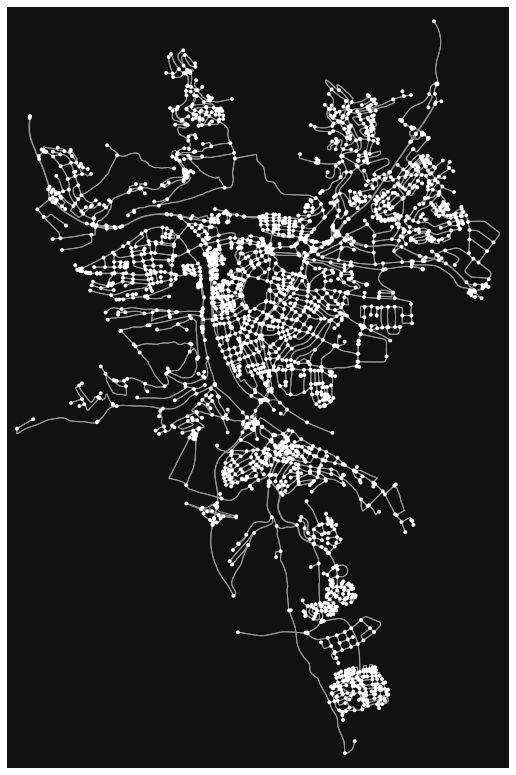

In [52]:
# Check the route for these two points since the network dist matrix seems to have a problem (said over 5000metres but the points are very close)

coord = (49.751875, 9.933932)
coord1 = (49.751798, 9.927970)

target_1 = ox.get_nearest_node(G, coord)
target_2 = ox.get_nearest_node(G, coord1)


route = ox.shortest_path(G, target_1, target_2, weight= "length")

fig, ax = ox.plot_graph_route(G, route, figsize= (14,14))



C:\Users\michi\Anaconda3\envs\ox\lib\site-packages\osmnx\distance.py:356: UserWarning: The `get_nearest_node` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


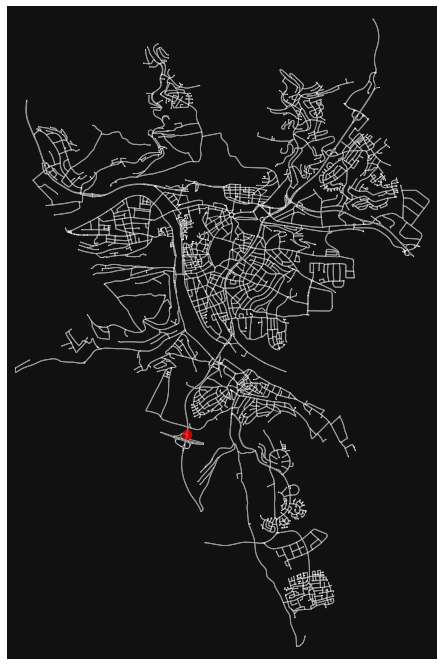

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

In [57]:
coord = (49.804200,	9.918704)
coord1 = (49.753819, 9.928881)
ox.plot_graph_route(G, [ox.get_nearest_node(G, (coord1))], figsize = (12,12), node_size = 1)



In [ ]:
# Check Long Distance Routes
# Get not only würzburg but vast area with bbox and try to plot a route from outside to city center

In [ ]:
fig, ax = ox.plot_graph_route(G, route, figsize= (14,14))

In [ ]:
# annotation
import matplotlib.pyplot as plt
import osmnx as ox
ox.config(use_cache=True, log_console=True)

G = ox.graph_from_address('Piedmont, CA, USA', dist=200, network_type='drive')
G = ox.get_undirected(G)

fig, ax = ox.plot_graph(G, bgcolor='k', edge_linewidth=3, node_size=0,
                        show=False, close=False)
for _, edge in ox.graph_to_gdfs(G, nodes=False).fillna('').iterrows():
    c = edge['geometry'].centroid
    text = edge['name']
    ax.annotate(text, (c.x, c.y), c='w')
plt.show()